In [1]:
import pandas as pd

df = pd.read_csv('epc_with_population.csv')
tags = pd.read_csv('epc_pop_field_tags.csv')

C:\Users\chen\AppData\Local\Temp\ipykernel_20620\1535179285.py:3: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('epc_with_population.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854276 entries, 0 to 854275
Data columns (total 85 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   LMK_KEY                        854276 non-null  object 
 1   ADDRESS1                       854276 non-null  object 
 2   ADDRESS2                       474554 non-null  object 
 3   POSTCODE                       854276 non-null  object 
 4   BUILDING_REFERENCE_NUMBER      854276 non-null  int64  
 5   CURRENT_ENERGY_RATING          854276 non-null  object 
 6   POTENTIAL_ENERGY_RATING        854276 non-null  object 
 7   CURRENT_ENERGY_EFFICIENCY      854276 non-null  int64  
 8   POTENTIAL_ENERGY_EFFICIENCY    854276 non-null  int64  
 9   PROPERTY_TYPE                  854276 non-null  object 
 10  BUILT_FORM                     854276 non-null  object 
 11  INSPECTION_DATE                854276 non-null  object 
 12  CONSTITUENCY                  

In [4]:
print(df['year'].unique())

[2019 2018 2016 2020 2017 2014 2015 2013 2023 2021 2022]


# Step1 Convert field types

## datetime

In [9]:
date_cols = ['INSPECTION_DATE', 'LODGEMENT_DATE', 'LODGEMENT_DATETIME']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors = 'coerce')

# check
print(df[date_cols].dtypes)

INSPECTION_DATE       datetime64[ns]
LODGEMENT_DATE        datetime64[ns]
LODGEMENT_DATETIME    datetime64[ns]
dtype: object


# Step2 Missing values and Sparsity analysis

## 2.1 thresholds

In [13]:
import numpy as np

zero_threshold = 0.9
missing_threshold = 0.9
low_unique_threshold = 1

# calculate
missing_ratio = df.isnull().mean()
zero_ratio = df.select_dtypes(include = np.number).apply(lambda x : (x == 0).mean())
unique_counts = df.nunique(dropna = False)

# summarize
field_analysis = pd.DataFrame({
    'missing_ratio': missing_ratio,
    'zero_ratio': zero_ratio.reindex(df.columns),
    'unique_counts': unique_counts
}, index = df.columns)

## 2.2 Labeling

In [16]:
def classify_field(row):
    if row['missing_ratio'] > missing_threshold or row['zero_ratio'] > zero_threshold or row['unique_counts'] <= low_unique_threshold:
        return 'drop_lstm'
    else:
        return 'keep_core'

field_analysis['keep_tag'] = field_analysis.apply(classify_field, axis=1)

# output
print(field_analysis['keep_tag'].value_counts())

# check drop
drop_fields = field_analysis[field_analysis['keep_tag'] == 'drop_lstm']
display(drop_fields)

keep_tag
keep_core    85
Name: count, dtype: int64


,missing_ratio,zero_ratio,unique_counts,keep_tag


# Step3 EDA

## Annual unit area energy consumption

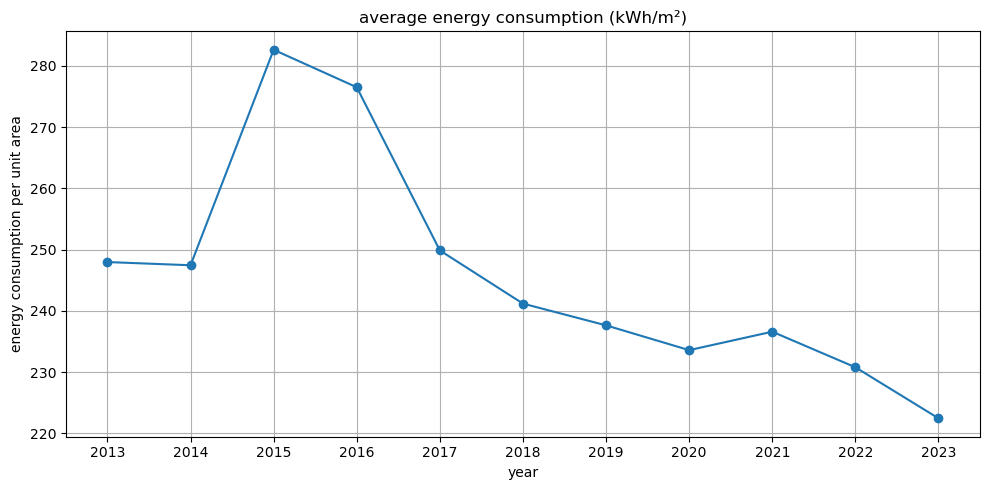

In [20]:
import matplotlib.pyplot as plt
# delete missing values
df_valid = df[~df['ENERGY_CONSUMPTION_CURRENT'].isna() & (df['ENERGY_CONSUMPTION_CURRENT'] > 0)]
# mean values bu year
avg_energy_per_year = df_valid.groupby('year')['ENERGY_CONSUMPTION_CURRENT'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(
    avg_energy_per_year['year'],
    avg_energy_per_year['ENERGY_CONSUMPTION_CURRENT'],
    marker='o'
)
plt.title('average energy consumption (kWh/m²)')
plt.xlabel('year')
plt.ylabel('energy consumption per unit area')
plt.xticks(range(2013, 2024))
plt.grid(True)
plt.tight_layout()
plt.show()

## Mean unit area energy consumption by regions

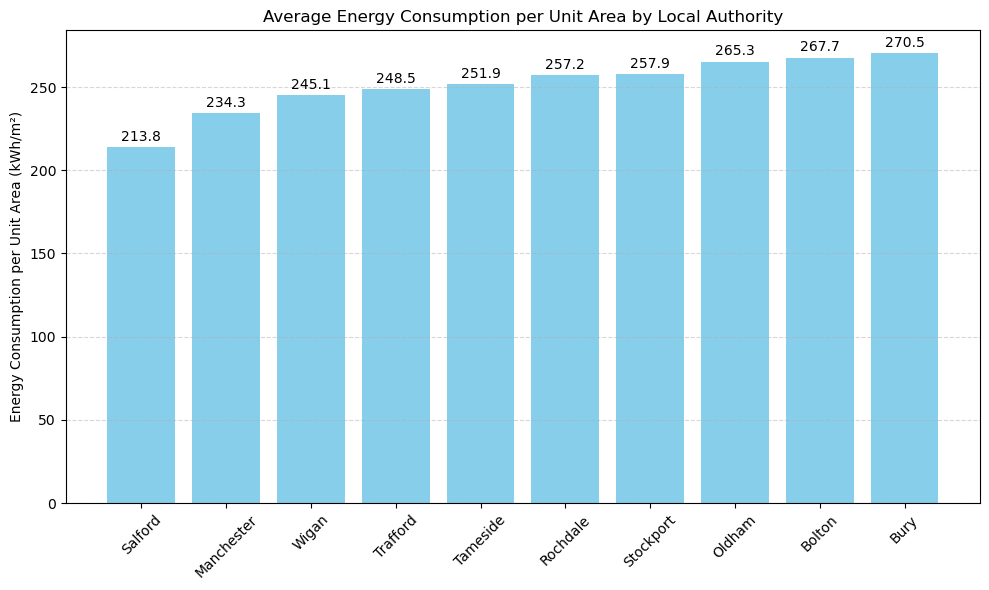

In [23]:
# Mean by regions
avg_energy_by_area = df_valid.groupby('LOCAL_AUTHORITY')['ENERGY_CONSUMPTION_CURRENT'].mean().sort_values()
area_name_mapping = {
    'E08000001': 'Bolton',
    'E08000002': 'Bury',
    'E08000003': 'Manchester',
    'E08000004': 'Oldham',
    'E08000005': 'Rochdale',
    'E08000006': 'Salford',
    'E08000007': 'Stockport',
    'E08000008': 'Tameside',
    'E08000009': 'Trafford',
    'E08000010': 'Wigan'
}
avg_energy_by_area.index = avg_energy_by_area.index.map(area_name_mapping)

import matplotlib.pyplot as plt

# ascending order
avg_energy_by_area = avg_energy_by_area.sort_values()


plt.figure(figsize=(10, 6))
bars = plt.bar(avg_energy_by_area.index, avg_energy_by_area.values, color='skyblue')

# number labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f'{height:.1f}', ha='center', va='bottom')

plt.ylabel('Energy Consumption per Unit Area (kWh/m²)')
plt.title('Average Energy Consumption per Unit Area by Local Authority')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Unit area energy consumption by property types

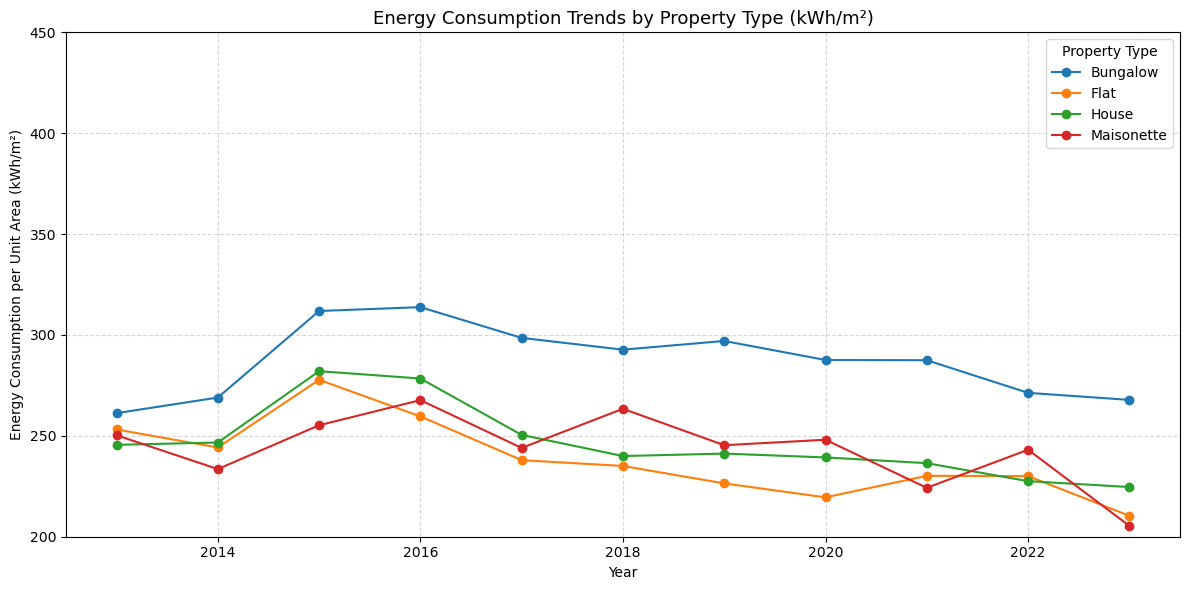

In [26]:
# drop missing values
df_c2 = df[['PROPERTY_TYPE', 'INSPECTION_DATE', 'ENERGY_CONSUMPTION_CURRENT']].dropna()

df_c2['year'] = df_c2['INSPECTION_DATE'].dt.year

# remain building types with more than 500 samples
major_types = df_c2['PROPERTY_TYPE'].value_counts()
valid_types = major_types[major_types > 500].index
df_c2 = df_c2[df_c2['PROPERTY_TYPE'].isin(valid_types)]

# group mean values
trend_data = df_c2.groupby(['PROPERTY_TYPE', 'year'])['ENERGY_CONSUMPTION_CURRENT'].mean().reset_index()

plt.figure(figsize=(12, 6))
for prop_type in trend_data['PROPERTY_TYPE'].unique():
    data = trend_data[trend_data['PROPERTY_TYPE'] == prop_type]
    plt.plot(data['year'], data['ENERGY_CONSUMPTION_CURRENT'], marker='o', label=prop_type)

plt.title('Energy Consumption Trends by Property Type (kWh/m²)', fontsize=13)
plt.xlabel('Year')
plt.ylabel('Energy Consumption per Unit Area (kWh/m²)')
plt.legend(title='Property Type')
plt.ylim(200, 450)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Explore why energy consumption decrease

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
df_ext = df.copy()

In [33]:
keep_cols = [
    'year',
    'ENERGY_CONSUMPTION_CURRENT',
    'CURRENT_ENERGY_RATING',
    'CURRENT_ENERGY_EFFICIENCY',
    'MAIN_FUEL',
    'TOTAL_FLOOR_AREA',
    'LOCAL_AUTHORITY'
]
df_ext = df_ext[keep_cols].dropna(subset=['year', 'ENERGY_CONSUMPTION_CURRENT'])

In [35]:
# convert year
df_ext['year'] = pd.to_numeric(df_ext['year'], errors='coerce').astype('Int64')
df_ext = df_ext.dropna(subset=['year'])
df_ext['year'] = df_ext['year'].astype(int)

# sort the ratings
rating_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df_ext['CURRENT_ENERGY_RATING'] = (
    df_ext['CURRENT_ENERGY_RATING']
      .astype(str).str.strip().str.upper()
      .where(lambda s: s.isin(rating_order), other=np.nan)
)
df_ext['CURRENT_ENERGY_RATING'] = pd.Categorical(
    df_ext['CURRENT_ENERGY_RATING'], categories=rating_order, ordered=True
)

# Unify main fuel labels
def normalize_fuel(x: str) -> str:
    if not isinstance(x, str):
        return 'Other'
    s = x.strip().lower()
    if 'electric' in s:
        return 'Electricity'
    if 'mains gas' in s or s == 'gas' or 'natural gas' in s:
        return 'Gas'
    if 'lpg' in s or 'bottled' in s:
        return 'LPG'
    if 'oil' in s:
        return 'Oil'
    if 'coal' in s or 'solid' in s or 'anthracite' in s:
        return 'Solid Fuel'
    if 'biomass' in s or 'wood' in s or 'pellet' in s:
        return 'Biomass/Wood'
    if 'community' in s or 'district' in s or 'heat network' in s:
        return 'District Heating'
    return 'Other'

df_ext['MAIN_FUEL_NORM'] = df_ext['MAIN_FUEL'].astype(str).map(normalize_fuel)

ycol = 'ENERGY_CONSUMPTION_CURRENT'

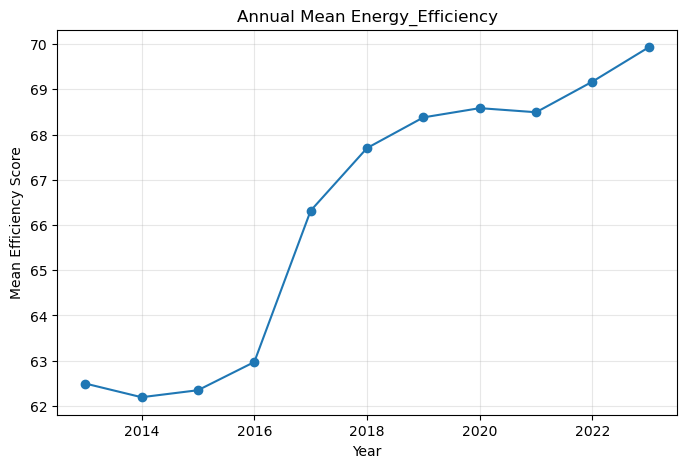

In [37]:
# Annual efficiency scores
eff_year = (
    df_ext.dropna(subset=['CURRENT_ENERGY_EFFICIENCY'])
         .groupby('year', as_index=False)['CURRENT_ENERGY_EFFICIENCY'].mean()
)

plt.figure(figsize=(8,5))
plt.plot(eff_year['year'], eff_year['CURRENT_ENERGY_EFFICIENCY'], marker='o')
plt.title('Annual Mean Energy_Efficiency')
plt.xlabel('Year')
plt.ylabel('Mean Efficiency Score')
plt.grid(alpha=0.3)
plt.show()

In [39]:
# Ratings change trend
rating_year = (
    df_ext.dropna(subset=['CURRENT_ENERGY_RATING'])
         .groupby(['year','CURRENT_ENERGY_RATING']).size()
         .reset_index(name='count')
)
rating_year['ratio'] = rating_year.groupby('year')['count'].transform(lambda s: s/s.sum())

C:\Users\chen\AppData\Local\Temp\ipykernel_20620\5432516.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year','CURRENT_ENERGY_RATING']).size()


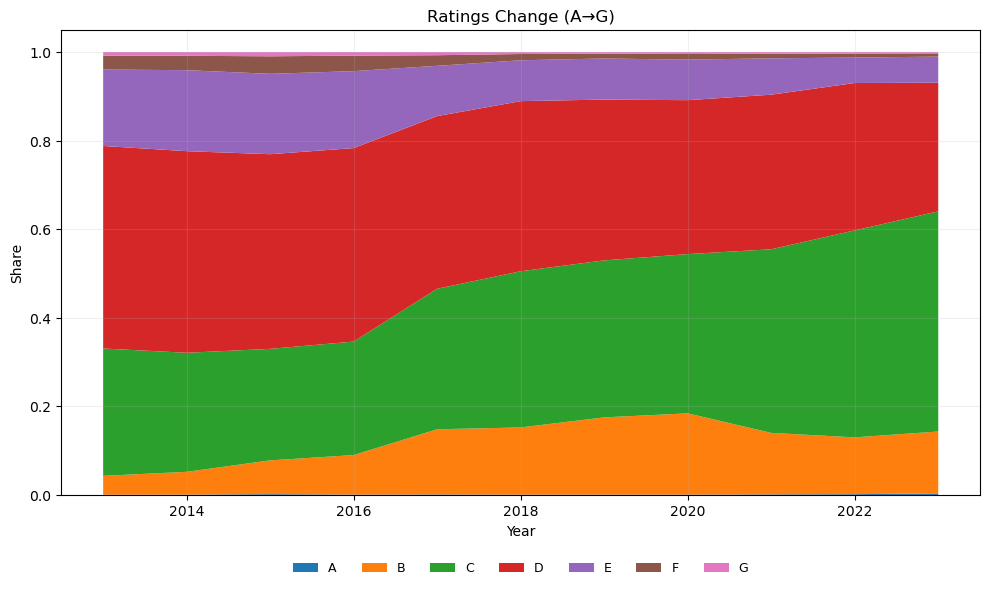

In [41]:
pivot_rating = rating_year.pivot(index='year', columns='CURRENT_ENERGY_RATING', values='ratio').fillna(0.0)

pivot_rating = pivot_rating[rating_order]
plt.figure(figsize=(10,6))
plt.stackplot(pivot_rating.index, pivot_rating.T.values, labels=pivot_rating.columns)
plt.title('Ratings Change (A→G)')
plt.xlabel('Year')
plt.ylabel('Share')

plt.grid(alpha=0.2)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=len(pivot_rating.columns), 
    fontsize=9,
    frameon=False
)

plt.tight_layout()
plt.show()

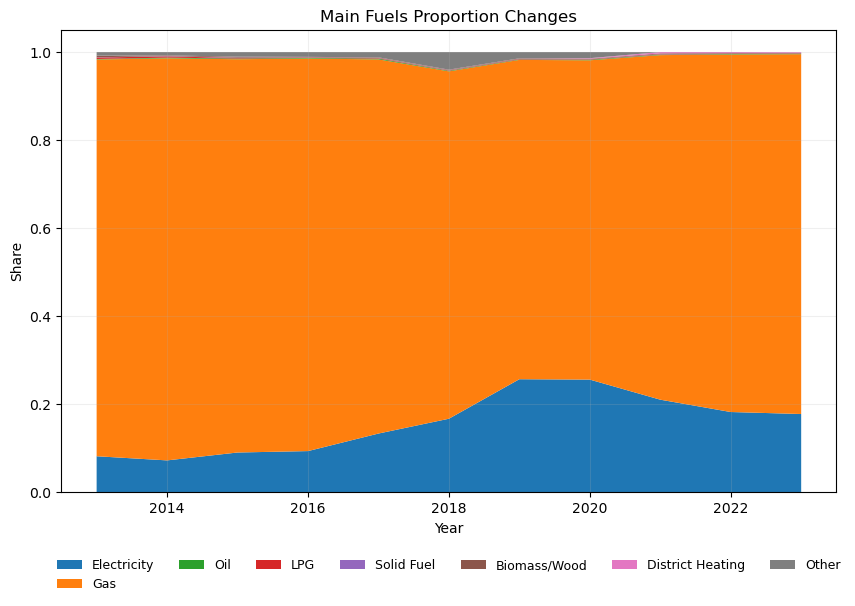

In [43]:
# fuel proportion trend
fuel_year = (
    df_ext.groupby(['year','MAIN_FUEL_NORM']).size()
          .reset_index(name='count')
)
fuel_year['ratio'] = fuel_year.groupby('year')['count'].transform(lambda s: s/s.sum())

# only show main types
major_fuels = ['Electricity','Gas','Oil','LPG','Solid Fuel','Biomass/Wood','District Heating','Other']
pivot_fuel = fuel_year.pivot(index='year', columns='MAIN_FUEL_NORM', values='ratio').fillna(0.0)

for f in major_fuels:
    if f not in pivot_fuel.columns:
        pivot_fuel[f] = 0.0
pivot_fuel = pivot_fuel[major_fuels]

plt.figure(figsize=(10,6))
plt.stackplot(pivot_fuel.index, pivot_fuel.T.values, labels=pivot_fuel.columns)
plt.title('Main Fuels Proportion Changes')
plt.xlabel('Year')
plt.ylabel('Share')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=len(pivot_rating.columns), 
    fontsize=9,
    frameon=False
)
plt.grid(alpha=0.2)
plt.show()

# Step4 Filter variable subsets

## 4.1 Selecting

In [47]:
# 1.manual selesting
selected_fields = [
    'ENERGY_CONSUMPTION_CURRENT', # target

    # structure and age
    'PROPERTY_TYPE', 'BUILT_FORM', 'CONSTRUCTION_AGE_BAND', 'TOTAL_FLOOR_AREA',
    'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT', 'FLOOR_HEIGHT',
    'EXTENSION_COUNT', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS', 'HEAT_LOSS_CORRIDOR',

    # envelop efficiency
    'GLAZED_TYPE', 'GLAZED_AREA', 'MULTI_GLAZE_PROPORTION',
    'WINDOWS_ENERGY_EFF', 'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF', 'FLOOR_ENERGY_EFF',

    # energy system
    'MAINHEAT_DESCRIPTION', 'MAIN_HEATING_CONTROLS',
    'HOTWATER_DESCRIPTION', 'LOW_ENERGY_LIGHTING', 'LIGHTING_ENERGY_EFF',
    'SOLAR_WATER_HEATING_FLAG', 'PHOTO_SUPPLY', 'MECHANICAL_VENTILATION',

    # temporal, spatial
    'INSPECTION_DATE', 'year', 'LOCAL_AUTHORITY', 'TRANSACTION_TYPE',

    # for building counts
    'BUILDING_REFERENCE_NUMBER',

    # population
     'population',

    # for determining whether electrification
    'MAIN_FUEL',

    # tenure types
    'TENURE'
]

In [49]:
# 2.filter existing fields
existing_fields = [f for f in selected_fields if f in df.columns]
df_energy_factors = df[existing_fields].copy()

In [51]:
df_energy_factors.to_csv('df_energy_factors.csv')

In [52]:
# 3.make sure datetime
import numpy as np
if not np.issubdtype(df_energy_factors['INSPECTION_DATE'].dtype, np.datetime64):
    df_energy_factors['INSPECTION_DATE'] = pd.to_datetime(df_energy_factors['INSPECTION_DATE'], errors='coerce')

In [53]:
# 4.check year
if 'year' not in df_energy_factors.columns:
    df_energy_factors['year'] = df_energy_factors['INSPECTION_DATE'].dt.year

In [54]:
# 5.remain valid records
df_energy_factors = df_energy_factors[
    (df_energy_factors['ENERGY_CONSUMPTION_CURRENT'].notna()) &
    (df_energy_factors['ENERGY_CONSUMPTION_CURRENT'] > 0)
]

In [55]:
# check
print(f'number of fields：{df_energy_factors.shape[1]}')
print(f'number of samples：{df_energy_factors.shape[0]}')
df_energy_factors.head()

number of fields：35
number of samples：854153


,ENERGY_CONSUMPTION_CURRENT,PROPERTY_TYPE,BUILT_FORM,CONSTRUCTION_AGE_BAND,TOTAL_FLOOR_AREA,FLOOR_LEVEL,FLAT_TOP_STOREY,FLOOR_HEIGHT,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,...,PHOTO_SUPPLY,MECHANICAL_VENTILATION,INSPECTION_DATE,year,LOCAL_AUTHORITY,TRANSACTION_TYPE,BUILDING_REFERENCE_NUMBER,population,MAIN_FUEL,TENURE
0,262,Bungalow,Detached,England and Wales: 1950-1966,148.0,NODATA!,NaN,NaN,2.0,8.0,...,NaN,natural,2019-10-02,2019,E08000001,marketed sale,1996,294888,mains gas (not community),owner-occupied
1,242,House,Detached,England and Wales: 1967-1975,114.0,NODATA!,NaN,NaN,1.0,9.0,...,NaN,natural,2018-06-02,2018,E08000001,marketed sale,48578,291594,mains gas (not community),owner-occupied
2,199,House,Semi-Detached,England and Wales: 1976-1982,73.0,NODATA!,NaN,NaN,0.0,4.0,...,NaN,natural,2018-08-10,2018,E08000001,rental (social),400568,291594,mains gas (not community),rental (social)
3,97,House,End-Terrace,NO DATA!,75.0,NO DATA!,NaN,NaN,NaN,NaN,...,NaN,NO DATA!,2016-10-03,2016,E08000001,new dwelling,586478,287253,mains gas - this is for backwards compatibilit...,rental (social)
4,327,House,Mid-Terrace,England and Wales: before 1900,92.0,NODATA!,NaN,2.6,0.0,4.0,...,NaN,natural,2016-10-06,2016,E08000001,marketed sale,967478,287253,mains gas (not community),owner-occupied


In [56]:
# check dtypes and missing ratio
summary = pd.DataFrame({
    'dtype': df_energy_factors.dtypes,
    'non_null_count': df_energy_factors.notnull().sum(),
    'null_count': df_energy_factors.isnull().sum(),
    'null_pct': df_energy_factors.isnull().mean().round(3)
}).sort_values(by='null_pct', ascending=False)

summary

,dtype,non_null_count,null_count,null_pct
FLAT_TOP_STOREY,object,224221,629932,0.737
FLOOR_HEIGHT,float64,287257,566896,0.664
FLOOR_ENERGY_EFF,object,393649,460504,0.539
PHOTO_SUPPLY,float64,415983,438170,0.513
MAIN_HEATING_CONTROLS,float64,542238,311915,0.365
SOLAR_WATER_HEATING_FLAG,object,547220,306933,0.359
HEAT_LOSS_CORRIDOR,object,672561,181592,0.213
FLOOR_LEVEL,object,692457,161696,0.189
ROOF_ENERGY_EFF,object,697452,156701,0.183
NUMBER_HABITABLE_ROOMS,float64,754372,99781,0.117


In [57]:
# check unique values counts
object_cols = df_energy_factors.select_dtypes(include='object').columns

for col in object_cols:
    print(f'{col}: {df_energy_factors[col].nunique()}')

PROPERTY_TYPE: 5
BUILT_FORM: 7
CONSTRUCTION_AGE_BAND: 47
FLOOR_LEVEL: 97
FLAT_TOP_STOREY: 2
HEAT_LOSS_CORRIDOR: 4
GLAZED_TYPE: 10
GLAZED_AREA: 6
WINDOWS_ENERGY_EFF: 5
WALLS_ENERGY_EFF: 5
ROOF_ENERGY_EFF: 5
FLOOR_ENERGY_EFF: 6
MAINHEAT_DESCRIPTION: 167
HOTWATER_DESCRIPTION: 64
LIGHTING_ENERGY_EFF: 5
SOLAR_WATER_HEATING_FLAG: 2
MECHANICAL_VENTILATION: 4
LOCAL_AUTHORITY: 10
TRANSACTION_TYPE: 18
MAIN_FUEL: 38
TENURE: 9


## 4.2 suggestion table

In [66]:
# field analysis
df_info = df_energy_factors.dtypes.reset_index()
df_info.columns = ['field', 'dtype']
df_info['dtype'] = df_info['dtype'].astype(str)

# ratios as above
df_info['non_null_count'] = df_energy_factors.count().values
df_info['null_count'] = df_energy_factors.isnull().sum().values
df_info['null_pct'] = df_info['null_count'] / df_energy_factors.shape[0]

In [68]:
# count number of categories for object
df_info['nunique'] = df_info['field'].apply(
    lambda col: df_energy_factors.get(col).nunique()
    if pd.api.types.is_object_dtype(df_energy_factors.get(col)) else None
)

In [69]:
# classification
def classify_type(row):
    if 'datetime' in row['dtype']:
        return 'date'
    elif row['dtype'] in ['float64', 'int64']:
        return 'numeric'
    elif row['dtype'] == 'object':
        return 'categorical'
    else:
        return 'other'


df_info['var_type'] = df_info.apply(classify_type, axis=1)

In [72]:
# treatment
def suggest_method(row):
    if row['var_type'] == 'numeric':
        if row['null_pct'] > 0.5:
            return 'consider drop (many nulls)'
        else:
            return 'impute & scale'
    elif row['var_type'] == 'categorical':
        if row['nunique'] is not None and row['nunique'] <= 10:
            return 'one-hot encode'
        elif row['nunique'] is not None and row['nunique'] <= 100:
            return 'target/frequency encode'
        else:
            return 'consider drop or group'
    elif row['var_type'] == 'date':
        return 'extract year / month'
    else:
        return 'check manually'

df_info['suggestion'] = df_info.apply(suggest_method, axis=1)

print(df_info.columns.tolist())

['field', 'dtype', 'non_null_count', 'null_count', 'null_pct', 'nunique', 'var_type', 'suggestion']


In [74]:
print(df_info[
      ['field', 'dtype', 'non_null_count', 'null_count', 'null_pct', 'nunique', 'var_type', 'suggestion']
      ].head(20))

                         field    dtype  non_null_count  null_count  null_pct  \
0   ENERGY_CONSUMPTION_CURRENT    int64          854153           0  0.000000   
1                PROPERTY_TYPE   object          854153           0  0.000000   
2                   BUILT_FORM   object          854153           0  0.000000   
3        CONSTRUCTION_AGE_BAND   object          847449        6704  0.007849   
4             TOTAL_FLOOR_AREA  float64          854153           0  0.000000   
5                  FLOOR_LEVEL   object          692457      161696  0.189306   
6              FLAT_TOP_STOREY   object          224221      629932  0.737493   
7                 FLOOR_HEIGHT  float64          287257      566896  0.663694   
8              EXTENSION_COUNT  float64          754372       99781  0.116819   
9       NUMBER_HABITABLE_ROOMS  float64          754372       99781  0.116819   
10         NUMBER_HEATED_ROOMS  float64          754372       99781  0.116819   
11          HEAT_LOSS_CORRID

## 4.3 Operate based on suggestion

In [77]:
from sklearn.preprocessing import MinMaxScaler

# selscting numeric fields
num_drop_cols = df_info[(df_info['var_type'] == 'numeric') & (df_info['suggestion'] == 'consider drop (many nulls)')]['field'].tolist()
num_impute_cols = df_info[(df_info['var_type'] == 'numeric') & (df_info['suggestion'] == 'impute & scale')]['field'].tolist()

# drop
df_model = df_energy_factors.drop(columns=num_drop_cols)

# impute scale
for col in num_impute_cols:
    df_model[col] = df_model[col].fillna(df_model[col].median())

scaler = MinMaxScaler()
df_model[num_impute_cols] = scaler.fit_transform(df_model[num_impute_cols])

In [78]:
# 1.one hot
onehot_cols = df_info[(df_info['var_type'] == 'categorical') & (df_info['suggestion'] == 'one-hot encode')]['field'].tolist()
df_model = pd.get_dummies(df_model, columns=onehot_cols, drop_first=True)

# 2.Frequency / Target
freq_encode_cols = df_info[(df_info['var_type'] == 'categorical') & (df_info['suggestion'] == 'target/frequency encode')]['field'].tolist()
for col in freq_encode_cols:
    freq_map = df_model[col].value_counts(normalize=True)
    df_model[col] = df_model[col].map(freq_map)

# 3.drop or group
drop_high_card_cols = df_info[(df_info['suggestion'] == 'consider drop or group')]['field'].tolist()
df_model = df_model.drop(columns=drop_high_card_cols)

In [80]:
df_model.to_csv('df_model.csv', index=False)

# Step5 Construct multivariable LSTM series

## 5.1 Merge population

In [85]:
import pandas as pd

In [87]:
bolton_pop = pd.read_csv('Bolton_chart-timeseries.csv', skiprows=6, names=['year', 'population'])

# Drop missing year
bolton_pop = bolton_pop[bolton_pop['year'].apply(lambda x: str(x).isdigit())]
bolton_pop['year'] = bolton_pop['year'].astype(int)

# remain 2024-2035
bolton_pop = bolton_pop[(bolton_pop['year'] >= 2024) & (bolton_pop['year'] <= 2035)]

bolton_pop = bolton_pop.reset_index(drop=True)

# add LOCAL_AUTHORITY
bolton_pop['LOCAL_AUTHORITY'] = 'E08000001'

# adjust cols order
bolton_pop = bolton_pop[['year', 'LOCAL_AUTHORITY', 'population']]
bolton_pop['population'] = bolton_pop['population'].astype(int)

print(bolton_pop)

    year LOCAL_AUTHORITY  population
0   2024       E08000001      304084
1   2025       E08000001      304993
2   2026       E08000001      305567
3   2027       E08000001      306113
4   2028       E08000001      306722
5   2029       E08000001      307418
6   2030       E08000001      308153
7   2031       E08000001      308895
8   2032       E08000001      309657
9   2033       E08000001      310448
10  2034       E08000001      311275
11  2035       E08000001      312116


In [89]:
bolton_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year             12 non-null     int32 
 1   LOCAL_AUTHORITY  12 non-null     object
 2   population       12 non-null     int32 
dtypes: int32(2), object(1)
memory usage: 324.0+ bytes


In [91]:
local_authorities = {
    'Bolton': 'E08000001',
    'Bury': 'E08000002',
    'Manchester': 'E08000003',
    'Oldham': 'E08000004',
    'Rochdale': 'E08000005',
    'Salford': 'E08000006',
    'Stockport': 'E08000007',
    'Tameside': 'E08000008',
    'Trafford': 'E08000009',
    'Wigan': 'E08000010'
}

In [93]:
# empty list for all dfs
dfs = []

# iterate all files
for district, la_code in local_authorities.items():
    file_name = f'{district}_chart-timeseries.csv'
    
    # read
    df = pd.read_csv(file_name, skiprows=6, names=['year', 'population'])
    
    # remain 2024-2035
    df = df[pd.to_numeric(df['year'], errors='coerce').notna()]
    df['year'] = df['year'].astype(int)
    df = df[(df['year'] >= 2024) & (df['year'] <= 2035)]
    
    # add Local Authority
    df['LOCAL_AUTHORITY'] = la_code
    
    # convert pop into int
    df['population'] = df['population'].astype(int)
    
    # reorder
    df = df[['year', 'LOCAL_AUTHORITY', 'population']]
    
    dfs.append(df)

# merge
forecast_population_df = pd.concat(dfs, ignore_index=True)

print(forecast_population_df.head(10))

   year LOCAL_AUTHORITY  population
0  2024       E08000001      304084
1  2025       E08000001      304993
2  2026       E08000001      305567
3  2027       E08000001      306113
4  2028       E08000001      306722
5  2029       E08000001      307418
6  2030       E08000001      308153
7  2031       E08000001      308895
8  2032       E08000001      309657
9  2033       E08000001      310448


## 5.2 Extract variables from df_model

In [96]:
df_model = pd.read_csv('df_model.csv')

### Restore one-hot encoding, period confirmation

In [99]:
# Restore local authority code
la_cols = [col for col in df_model.columns if col.startswith('LOCAL_AUTHORITY_')]

df_model['LOCAL_AUTHORITY'] = 'E08000001'

for col in la_cols:
    code = col.replace('LOCAL_AUTHORITY_', '')
    df_model.loc[df_model[col] == True, 'LOCAL_AUTHORITY'] = code

In [101]:
# check
print('E08000001' in df_model['LOCAL_AUTHORITY'].unique())

print(df_model['LOCAL_AUTHORITY'].unique())

True
['E08000001' 'E08000002' 'E08000003' 'E08000004' 'E08000005' 'E08000006'
 'E08000007' 'E08000008' 'E08000009' 'E08000010']


In [103]:
# check year and local_authority
assert 'year' in df_model.columns
assert 'LOCAL_AUTHORITY' in df_model.columns
assert 'ENERGY_CONSUMPTION_CURRENT' in df_model.columns

# make sure datetime type
df_model['INSPECTION_DATE'] = pd.to_datetime(df_model['INSPECTION_DATE'], errors='coerce')
df_model['year'] = df_model['INSPECTION_DATE'].dt.year

In [105]:
# Denormalization
from sklearn.preprocessing import MinMaxScaler

# new scaler
scalers = {}
original_values = {}

for col in ['ENERGY_CONSUMPTION_CURRENT', 'population', 'TOTAL_FLOOR_AREA']:
    col_data = df_energy_factors[[col]].dropna()
    scaler = MinMaxScaler()
    scaler.fit(col_data)
    scalers[col] = scaler # store trained scaler
    original_values[col] = scaler.inverse_transform(df_model[[col]])

# denormalized values as new cols
df_model['ENERGY_CONSUMPTION_CURRENT_RAW'] = original_values['ENERGY_CONSUMPTION_CURRENT']
df_model['population_RAW'] = original_values['population']
df_model['TOTAL_FLOOR_AREA_RAW'] = original_values['TOTAL_FLOOR_AREA']

In [107]:
# Construct LSTM series, one row per region per year
df_lstm_multi = df_model.groupby(['year', 'LOCAL_AUTHORITY']).agg({
    'ENERGY_CONSUMPTION_CURRENT_RAW': 'mean', # target
    'BUILDING_REFERENCE_NUMBER': 'count', # building counts
    'population_RAW': 'mean',
    'TOTAL_FLOOR_AREA_RAW': 'sum'# population
}).reset_index()

print(df_lstm_multi.head())

   year LOCAL_AUTHORITY  ENERGY_CONSUMPTION_CURRENT_RAW  \
0  2013       E08000001                      254.191412   
1  2013       E08000002                      258.762695   
2  2013       E08000003                      244.236543   
3  2013       E08000004                      257.004482   
4  2013       E08000005                      238.528280   

   BUILDING_REFERENCE_NUMBER  population_RAW  TOTAL_FLOOR_AREA_RAW  
0                      10480        281629.0              897752.0  
1                       7227        187093.0              626629.0  
2                      19451        510783.0             1532110.0  
3                       9816        227866.0              855179.0  
4                       8575        212503.0              719565.0  


In [109]:
print(df_lstm_multi['year'].unique())            # 2013–2023
print(df_lstm_multi['LOCAL_AUTHORITY'].nunique())  # 10 regions

[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
10


## 5.3 future data for LSTM

In [112]:
# merge future population（2024-2035）
forecast_population_df = forecast_population_df.rename(columns = {'population': 'population_RAW'})

# others are nan
forecast_population_df['ENERGY_CONSUMPTION_CURRENT_RAW'] = np.nan
forecast_population_df['building_count'] = np.nan
forecast_population_df['TOTAL_FLOOR_AREA_RAW'] = np.nan

# merge historical data
df_lstm_multi_full = pd.concat([df_lstm_multi, forecast_population_df], ignore_index = True)

In [114]:
# historical mean for building count and total area
historical_df = df_lstm_multi[df_lstm_multi['year'] <= 2023]
mean_building = historical_df.groupby('LOCAL_AUTHORITY')['BUILDING_REFERENCE_NUMBER'].mean()
mean_area = historical_df.groupby('LOCAL_AUTHORITY')['TOTAL_FLOOR_AREA_RAW'].mean()

# impute
df_lstm_multi_full['building_count'] = df_lstm_multi_full.apply(
    lambda row: mean_building[row['LOCAL_AUTHORITY']] if pd.isna(row['building_count']) else row['building_count'], axis = 1
)
df_lstm_multi_full['TOTAL_FLOOR_AREA_RAW'] = df_lstm_multi_full.apply(
    lambda row: mean_area[row['LOCAL_AUTHORITY']] if pd.isna(row['TOTAL_FLOOR_AREA_RAW']) else row['TOTAL_FLOOR_AREA_RAW'], axis = 1
)

In [116]:
print(df_lstm_multi_full.head())

   year LOCAL_AUTHORITY  ENERGY_CONSUMPTION_CURRENT_RAW  \
0  2013       E08000001                      254.191412   
1  2013       E08000002                      258.762695   
2  2013       E08000003                      244.236543   
3  2013       E08000004                      257.004482   
4  2013       E08000005                      238.528280   

   BUILDING_REFERENCE_NUMBER  population_RAW  TOTAL_FLOOR_AREA_RAW  \
0                    10480.0        281629.0              897752.0   
1                     7227.0        187093.0              626629.0   
2                    19451.0        510783.0             1532110.0   
3                     9816.0        227866.0              855179.0   
4                     8575.0        212503.0              719565.0   

   building_count  
0     7113.090909  
1     4954.818182  
2    17508.181818  
3     5998.000000  
4     5684.454545  


In [118]:
df_lstm_multi.to_csv('df_lstm_multi.csv', index=False)
forecast_population_df.to_csv('forecast_population_df.csv', index=False)

In [120]:
df_lstm_multi_full.to_csv('df_lstm_multi_full.csv', index=False)

## 5.4 Train LSTM (can be runned independently)

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import random
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
# fixed random seed for reproducibility

In [124]:
# deterministic mode (make sure no variance due to parallelism)
tf.config.experimental.enable_op_determinism()

In [125]:
df_full = pd.read_csv('df_lstm_multi_full.csv')

In [129]:
# parameters setting
features = ['ENERGY_CONSUMPTION_CURRENT_RAW', 'building_count', 'population_RAW', 'TOTAL_FLOOR_AREA_RAW']
n_steps = 3 # Sliding window size, using the past three years to predict the next year
forecast_years = list(range(2024, 2036)) # Predicting years
regions = df_full['LOCAL_AUTHORITY'].unique() # get lacodes

# for creating sliding window sequence
def create_sequences(data, n_steps): # create input-output pairs with historical data
    X, y = [], []
    for i in range(len(data) - n_steps): # frequency
        X.append(data[i: i+n_steps]) # using 3 data each time
        y.append(data[i+n_steps][0]) # target is the first variable
    return np.array(X), np.array(y)

# prediction distionary
forecast_results = {}

# main loop: one model per region
for region in regions:
    df_region = df_full[df_full['LOCAL_AUTHORITY'] == region].sort_values('year').copy()
    # data for current region, sorted by year
    
    # mark historical and future
    df_hist = df_region[df_region['year'] <= 2023]
    df_future = df_region[df_region['year'] >= 2024]
    
    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_hist[features]) # only historical data

    # build series
    X, y = create_sequences(scaled, n_steps) # using historical data
    X = X.reshape((X.shape[0], n_steps, len(features))) # sample number，step length，feature number
    
    # build model
    model = Sequential([
        LSTM(64, activation = 'relu', input_shape = (n_steps, len(features))), # 64 neurons
        Dense(1) # output layer one value
    ]) # parameters
    model.compile(optimizer = 'adam', loss = 'mse') # Adam optimizer
    model.fit(X, y, epochs = 100, verbose = 0) # train 100 epochs

    # construct prediction input window (n_steps rows at the end of history)
    all_scaled = scaler.transform(df_region[features]) # normalize all data
    current_window = all_scaled[len(df_hist) - n_steps: len(df_hist)] 
    # initial prediction window, taking last 3 years of historical data: 2021,2022,2023

    predictions = []

    for i in range(len(df_future)): # loop through each predicting year
        x_input = current_window.reshape((1, n_steps, len(features))) # 1，3，4
        y_pred_scaled = model.predict(x_input, verbose = 0)[0][0] # predict next year energy consumption (normalized)

        # update window
        next_row = all_scaled[len(df_hist) + i].copy() # get features of future years
        next_row[0] = y_pred_scaled # replace energy with predicted results
        current_window = np.vstack([current_window[1: ], next_row]) # remove the earliest year, add the new predicted year
    
        # denormalize energy
        dummy = np.zeros((1, len(features)))
        dummy[0] = next_row
        energy_unscaled = scaler.inverse_transform(dummy)[0][0] # input current data
        
        predictions.append(energy_unscaled)

    # result
    forecast_results[region] = predictions

# show result of one region
for region, preds in forecast_results.items():
    print(f'\nPredictions for {region} (2024-2035):')
    for year, val in zip(forecast_years, preds):
        print(f'{year}: {val: 2f} kWh/m2')
    break


D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to


Predictions for E08000001 (2024-2035):
2024:  243.826412 kWh/m2
2025:  241.514513 kWh/m2
2026:  240.948678 kWh/m2
2027:  240.447162 kWh/m2
2028:  240.118947 kWh/m2
2029:  239.910049 kWh/m2
2030:  239.709273 kWh/m2
2031:  239.507778 kWh/m2
2032:  239.289929 kWh/m2
2033:  239.057716 kWh/m2
2034:  238.812711 kWh/m2
2035:  238.551122 kWh/m2


In [131]:
# merge
import pandas as pd

df_predictions = pd.DataFrame([
    {'year': year, 'LOCAL_AUTHORITY': region, 'predicted_energy': energy}
    for region, values in forecast_results.items()
    for year, energy in zip(range(2024, 2024 + len(values)), values)
])

df_predictions = df_predictions.sort_values(by = ['LOCAL_AUTHORITY', 'year']).reset_index(drop = True)

In [133]:
df_predictions.to_csv('lstm_predicted_energy_2024_2035.csv', index = False)

In [135]:
import pandas as pd
df_predictions = pd.read_csv('lstm_predicted_energy_2024_2035.csv',dtype={
        'year': str,
        'LOCAL_AUTHORITY': str,
        'predicted_energy': float
    },
    keep_default_na=False
)

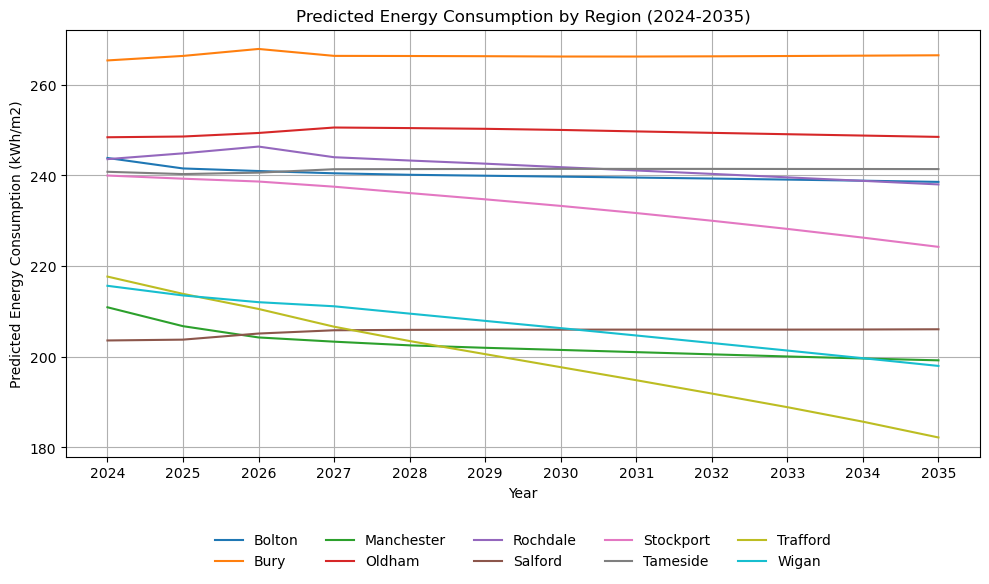

In [137]:
la_name_map = {
    'E08000001': 'Bolton',
    'E08000002': 'Bury',
    'E08000003': 'Manchester',
    'E08000004': 'Oldham',
    'E08000005': 'Rochdale',
    'E08000006': 'Salford',
    'E08000007': 'Stockport',
    'E08000008': 'Tameside',
    'E08000009': 'Trafford',
    'E08000010': 'Wigan'
}

plt.figure(figsize=(10, 6))

for region in df_predictions['LOCAL_AUTHORITY'].unique():
    df_region = df_predictions[df_predictions['LOCAL_AUTHORITY'] == region]
    region_name = la_name_map.get(region, region)
    plt.plot(df_region['year'], df_region['predicted_energy'], label=region_name)

plt.title('Predicted Energy Consumption by Region (2024-2035)')
plt.xlabel('Year')
plt.ylabel('Predicted Energy Consumption (kWh/m2)')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    frameon=False
)

plt.grid(True)
plt.tight_layout()
plt.show()

# Step6 Total energy Consumption

In [140]:
# toal= energy unit area*total area

df_full = pd.read_csv('df_lstm_multi_full.csv')
df_pred = pd.read_csv('lstm_predicted_energy_2024_2035.csv')


df_full = df_full.merge(df_pred, on=['year', 'LOCAL_AUTHORITY'], how='left')

df_full['predicted_total_energy'] = df_full['predicted_energy'] * df_full['TOTAL_FLOOR_AREA_RAW']

In [142]:
df_full.to_csv('df_lstm_total_energy_forecast.csv', index=False)

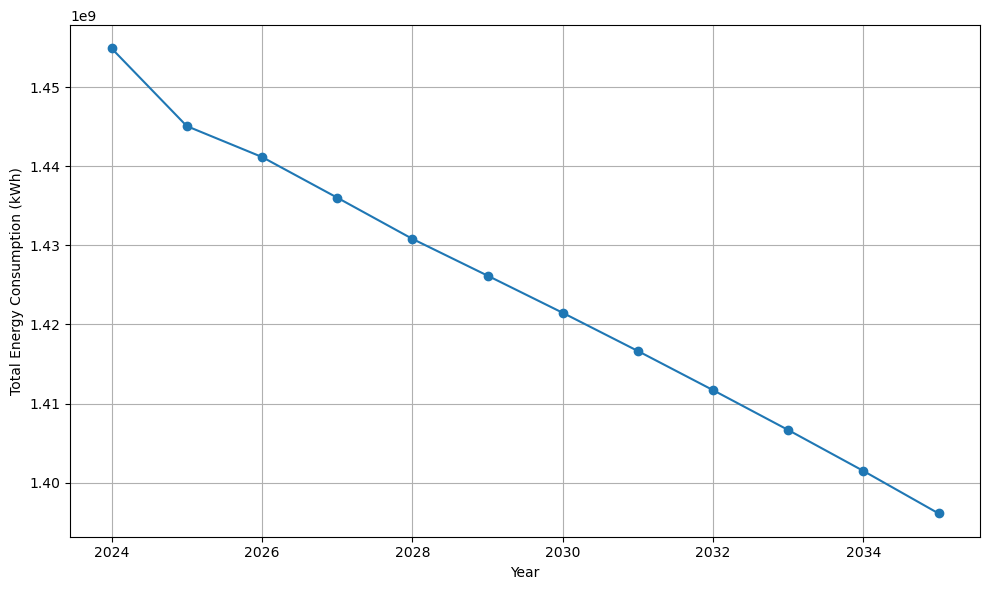

In [144]:
import matplotlib.pyplot as plt

# future year
df_future = df_full[df_full['year'] >= 2024]

# summarize
yearly_total = df_future.groupby('year')['predicted_total_energy'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_total['year'], yearly_total['predicted_total_energy'], marker='o')

plt.xlabel('Year')
plt.ylabel('Total Energy Consumption (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()


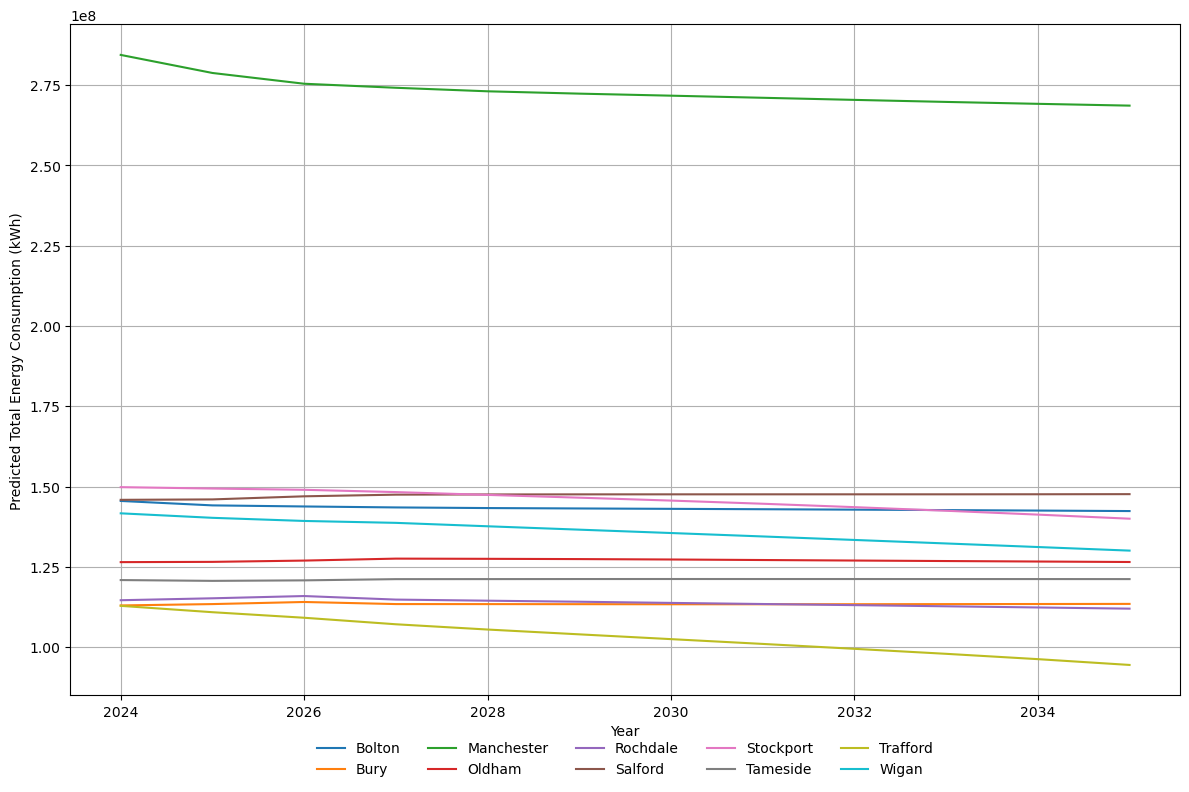

In [146]:
la_name_map = {
    'E08000001': 'Bolton',
    'E08000002': 'Bury',
    'E08000003': 'Manchester',
    'E08000004': 'Oldham',
    'E08000005': 'Rochdale',
    'E08000006': 'Salford',
    'E08000007': 'Stockport',
    'E08000008': 'Tameside',
    'E08000009': 'Trafford',
    'E08000010': 'Wigan'
}
df_forecast = df_full[(
    df_full['year'] >= 2024) & (df_full['year'] <= 2035) & (df_full['predicted_total_energy'].notna())].copy()
# Plot
plt.figure(figsize=(12, 8))
for la in df_forecast['LOCAL_AUTHORITY'].unique():
    d = df_forecast[df_forecast['LOCAL_AUTHORITY'] == la].sort_values('year')
    label = la_name_map.get(la, la)
    plt.plot(d['year'], d['predicted_total_energy'], label=label)

plt.xlabel('Year')
plt.ylabel('Predicted Total Energy Consumption (kWh)')

# Legend below, multiple columns
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False)

plt.grid(True)
plt.tight_layout()

plt.show()